# Solver using IP webCam
Yuqing Yang (*Github ID: mydmdm*)

## 1. Introduction
This notebook will give an demo of how to recognize an puzzle from the Camera of an Android device, solve it in the python script and then feedback the result to the picture. Actually there are multiple operations to accomplish this task, which will be covered in this notebook includes
+ read camera image (video) from an Android device by IP webCam 
+ segment the puzzle from the picture (making use of image processing algorithms in OpenCV)
+ digits recogniztion
+ solve puzzle using backtrack algorithm
+ write the results back to original picture

We will start from a pre-stored puzzle picture, and then connected to the camera. 

### Source code and Reference
You may get the source code from https://github.com/mydmdm/sudoku

This notebook is partly reference the resources from the website
- https://caphuuquan.blogspot.com/2017/04/building-simple-sudoku-solver-from.html
- http://www.shogun-toolbox.org/static/notebook/current/Sudoku_recognizer.html

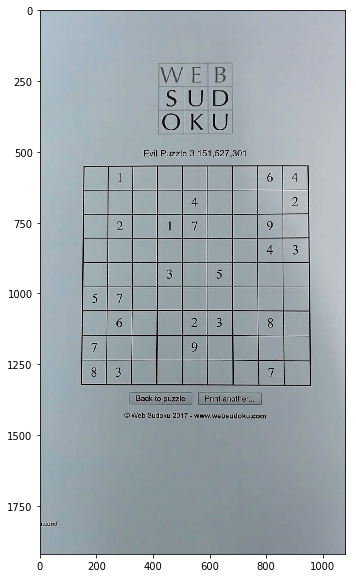

In [1]:
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import itertools
import json

# url is what shown in the IP web camera application
url='http://211.192.192.98:8080/shot.jpg'

# here is the example picture 
img = cv2.imread('example.jpg')

figsize = (15,10)
plt.figure(figsize=figsize)
_ = plt.imshow(img)

## 2. Segment the puzzle
The first task is to segment the puzzle from the picture. The basic assumption is that the puzzle is the biggest region with convex shape in the picture. 

Firstly, an *adaptativeThreshold* method is used to extract the edge of the image (for each pixel in the image take the average value of the surrounding area). This function accepts a gray scale image, with the function cvtColor we change the color space (from RGB to gray scale). 

Then the connected contours in the image are found by the function *findContours*. After that, we filter out the contour with four sides and *isContourConvex*. 

True

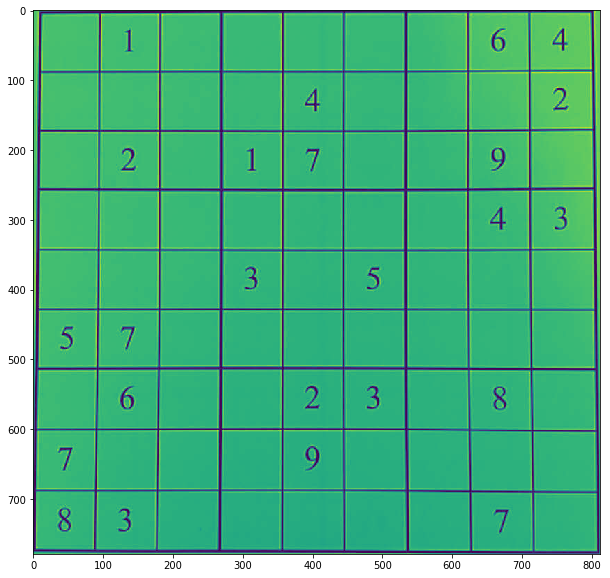

In [132]:
def getApproximateConvexArea(contour):
    appx = cv2.approxPolyDP(contour, 4, True)
    if len(appx)!=4 or not cv2.isContourConvex(appx):
        return 0
    return cv2.contourArea(appx)

def getContourImage(img, contour, target=None):
    x,y,w,h = cv2.boundingRect(contour)
    if target == None:
        w1, h1 = w, h
    elif w <= target[1] and h <= target[0]:
        w1, h1 = target[1], target[0]
    elif h/w <= target[1]/target[0]:
        w1, h1 = w, int(target[1]*w/target[0])
    else:
        w1, h1 = int(h*target[0]/target[1]), h
    x1, y1 = x + (w - w1)//2, y + (h - h1)//2
    rst = img[y1:y1+h1, x1:x1+w1]
    if w != w1 or h != h1:
        rst = cv2.resize(rst, target)
    return rst, [x1,y1,w1,h1]

def getBiggestConvexContour(img):
    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    area = [getApproximateConvexArea(c) for c in contours]
    k = np.argmax(np.array(area))
    return contours[k]

def segmentPuzzle(img):
    # smooth the picture (low-pass filtered)
    img_gray = cv2.blur(img, (3,3))
    
    # get the biggest convex contour and crop it out
    thr = cv2.adaptiveThreshold(img,255,1,1,15,15)    
    contour = getBiggestConvexContour(thr)
    img_puzzle, pos_puzzle = getContourImage(img, contour)
    return img_puzzle, pos_puzzle

# BGR format to gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_puzzle, pos_puzzle = segmentPuzzle(img_gray)
plt.figure(figsize=figsize)
_ = plt.imshow(img_puzzle)
cv2.imwrite('puzzle.jpg', img_puzzle)

## 3 Recognize the digits via Azure Cognitive Services
Here I use the Microsoft Azure Cognitive Service to do the digits recognitio work. What we need is just to upload the image and parse the jason file retrieved. 

And also we try to recognize the digits by using a locally trained CNN model and KNN model.

### 3.1 Split to digits
After getting the whole puzzle, the next step is to split it into pieces of digits. Of course, we can detect the lines and then split up the image based on them. However, to simpilify, one can split by equally slice the x / y axis into 9 pieces. If some of the digits are too close to the splitting boundaries, we may adjust them later. 

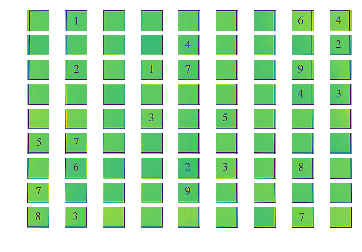

In [5]:
def getDigitImages(img):
    y = [int(k*img.shape[0]/9) for k in range(10)]
    x = [int(k*img.shape[1]/9) for k in range(10)]
    out = [[img[y[i]:y[i+1],x[j]:x[j+1]] for j in range(9)] for i in range(9)]
    return out

img_digits = getDigitImages(img_puzzle)
plt.figure(2)
for i in list(range(9)):
    for j in list(range(9)):
        plt.subplot(9,9,9*i+j+1)
        plt.imshow(img_digits[i][j])
        plt.axis('off')

You can see that there is still boundaries in the small pictures, and the digits are not scaled. So we need to further process the pictures.

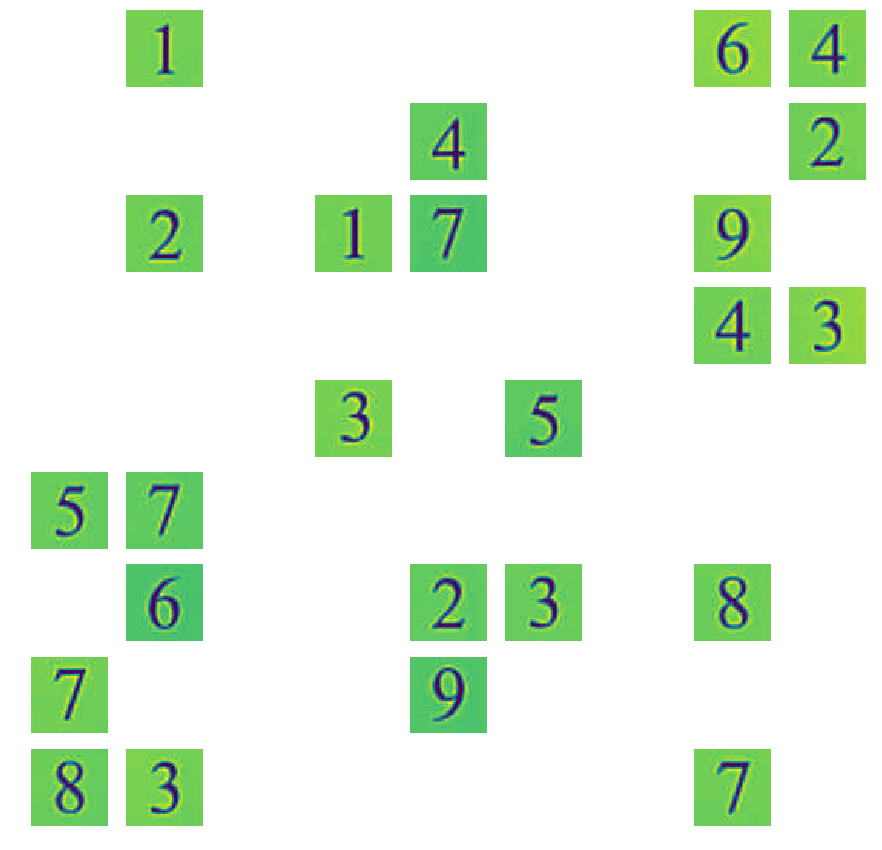

In [200]:
def contourCloseToBoundary(contour, img, thr=0.1):
    ymax, xmax = img.shape
    x,y,w,h = cv2.boundingRect(contour)
    rx = (x if x*2 + w <= xmax else xmax - (x+w)) / xmax
    ry = (y if y*2 + h <= ymax else ymax - (y+h)) / ymax
    return min(rx,ry) <= thr
       
def contourIsWholeImg(contour, img):
    ymax, xmax = img.shape
    x,y,w,h = cv2.boundingRect(contour)
    return x==0 and y==0 and w==xmax and h==ymax
    
def rescaleImage(img, shape=(28,28)):
    edges = np.copy(img)
    edges = cv2.adaptiveThreshold(edges,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,15)
    _, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    validCont = []
    for k in list(range(len(contours))):
        if contourIsWholeImg(contours[k],img) or contourCloseToBoundary(contours[k], img, thr=0.2):
            continue
        validCont.append(contours[k])
    if len(validCont) == 0:
        return True, img
    hull = cv2.convexHull(np.vstack(validCont))
    a = cv2.contourArea(hull) / (img.shape[0] * img.shape[1])
    if a < 0.01:
        return True, img
    rst, _ = getContourImage(img, hull, shape)
    return False, rst

img_mdl = [[[] for j in range(9)] for i in range(9)]
flagEmpty = np.zeros((9,9))
plt.figure(2,figsize=(15,15))
for i in list(range(9)):
    for j in list(range(9)):
        plt.subplot(9,9,9*i+j+1)
        flagEmpty[i][j], img_mdl[i][j] = rescaleImage(img_digits[i][j], (50,50))
        if not flagEmpty[i][j]:
            plt.imshow(img_mdl[i][j])
        plt.axis('off')
        

### 3.2 Recognize digits via Azure Cognitive Service
Since Azure Cognitive Services doesn't support recognizing individual digit, we try to split and re-combine the digits into one picture. 

(-0.5, 1199.5, 49.5, -0.5)

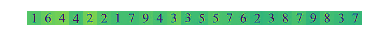

In [204]:
img_all_digits = np.concatenate([img_mdl[i][j] for i in range(9) for j in range(9) if not flagEmpty[i][j]], axis=1)
cv2.imwrite('all_digits.jpg', img_all_digits)
_ = plt.imshow(img_all_digits)
plt.axis('off')

Now I will try to recognize it using Azure service. Here is a reference
https://github.com/Microsoft/Cognitive-Vision-Python

In [339]:
'''
azCogSrvCfg = {
    "domain": "recognizeText",
    "region": "eastasia",
    "headers":{
        'Content-Type': "application/octet-stream",
        'Ocp-Apim-Subscription-Key': "",        
    },
    "params":{
        'handwriting': 'false',
    }
}
'''
with open('cognitive_service.json', 'r') as f:
    azCogSrvCfg = json.load(f)
    
def requestWrapper(method, url, params, maxNumRetries=10, retryCode=[429], exitCode=[200]):
    retries = 0
    while True:
        response = requests.request(method, url, **params)
        if response.status_code in exitCode:
            return response
        if response.status_code in retryCode:
            print( "Message: %s" % ( response.json() ) )
            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )
        break        
    return None
        

def azCognitiveServiceRecognizeText(cfg, data):
    url = 'https://%s.api.cognitive.microsoft.com/vision/v1.0/%s' % (cfg['region'], cfg['domain'])

    request_dict = dict()
    request_dict['headers'] = cfg['headers']
    request_dict['params'] = cfg['params']
    
    if cfg['headers']['Content-Type'] == 'application/json':
        request_dict['json'] = {'url':data}
    elif cfg['he

{'language': 'en', 'regions': [{'lines': [{'words': [{'text': '164422179433557623879837', 'boundingBox': '19,7,1167,37'}], 'boundingBox': '19,7,1167,37'}], 'boundingBox': '19,7,1167,37'}], 'orientation': 'Up', 'textAngle': 0.0}


Now we can retrieve the recognized digits and get the whole puzzle.

In [396]:
digits_str = result['regions'][0]['lines'][0]['words'][0]['text']
puzzle = np.zeros((9,9), dtype='int')
k = 0
for i in itertools.product(range(9), repeat=2):
    if not flagEmpty[i]:
        puzzle[i] = int(digits_str[k])
        k = k + 1
print(puzzle)

[[0 1 0 0 0 0 0 6 4]
 [0 0 0 0 4 0 0 0 2]
 [0 2 0 1 7 0 0 9 0]
 [0 0 0 0 0 0 0 4 3]
 [0 0 0 3 0 5 0 0 0]
 [5 7 0 0 0 0 0 0 0]
 [0 6 0 0 2 3 0 8 0]
 [7 0 0 0 9 0 0 0 0]
 [8 3 0 0 0 0 0 7 0]]


And save the pictures and labels of the digits for cross-validation of local model.

In [397]:
k = 0
x_test, y_test = [], []
for i in itertools.product(range(9), repeat=2):
    if not flagEmpty[i]:
        tmp = cv2.adaptiveThreshold(img_mdl[i[0]][i[1]],255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,15,15)
        x_test.append(tmp)
        y_test.append(int(digits_str[k]))
        k = k + 1
x_test, y_test = np.array(x_test), np.array(y_test)
np.savez('test', x_test, y_test)

## 4. Solve the Puzzle
Given the recognized puzzle, I use the backtrack algorithm to solve the puzzle. I use a very simple (not optimized) recursive implementation. Maybe will improve it later.

In [316]:
def solveForward(puzzle, n=9):
    values = np.copy(puzzle).astype('int')
    newInfo = True
    while newInfo:
        newInfo = False
        minFreedom, position, candidates = n, (-1,-1), []
        try:
            for idx in itertools.product(range(n), repeat=2):
                x,y = idx[0], idx[1]
                if values[x][y] > 0:
                    continue
                digit_found = np.zeros(n+1)
                digit_found[values[x,:]] = 1 # column 
                digit_found[values[:,y]] = 1 # row
                cell_x, cell_y = [(x//3)*3 + (i//3) for i in range(n)], [(y//3)*3 + (i%3) for i in range(n)]
                digit_found[values[cell_x, cell_y]] = 1 # cell
                digit_found = digit_found[1:] # remove uncertainty (zero)
                u = np.count_nonzero(digit_found == 0)
                v = np.argwhere(digit_found == 0) + 1
                if u == 0:
                    raise
                elif u == 1:
                    values[x][y] = v[0][0]
                    newInfo = True
                elif u <= minFreedom:
                    minFreedom, position, candidates = u, (x,y), v
        except:
            return 'failed', values
    status = 'solved' if np.count_nonzero(values == 0) == 0 else 'unfinished'
    if status == 'unfinished': # unfinished but not failed
        for v in candidates:
            puzzle_new = np.copy(values)
            puzzle_new[position] = v[0]
            status_new, solution_new = solveForward(puzzle_new)
            if status_new == 'solved':
                return status_new, solution_new
    return status, values

status, solution = solveForward(puzzle)
print(status)
print(solution)

solved
[[9 1 8 5 3 2 7 6 4]
 [6 5 7 8 4 9 1 3 2]
 [3 2 4 1 7 6 8 9 5]
 [2 8 6 9 1 7 5 4 3]
 [4 9 1 3 8 5 6 2 7]
 [5 7 3 2 6 4 9 1 8]
 [1 6 5 7 2 3 4 8 9]
 [7 4 2 6 9 8 3 5 1]
 [8 3 9 4 5 1 2 7 6]]


## 5. Represent solution to original image
It is good to draw the solution back to the original image.

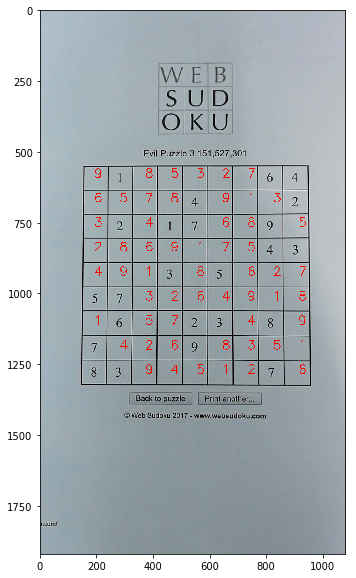

In [337]:
def getDigitPosition(pos, leftBottom):
    x, y, w, h = leftBottom
    return (x + int(w*(pos[1]+0.5)/9), y + int(h*(pos[0]+0.5)/9))

img_solution = np.copy(img)
for i in itertools.product(range(9), repeat=2):
    if puzzle[i] != 0:
        continue
    cv2.putText(img_solution, str(solution[i]), getDigitPosition(i,pos_puzzle), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 2)
plt.figure(figsize=figsize)
plt.imshow(img_solution)
_ = cv2.imwrite('solution.jpg', img_solution)

## 3.2.b (Optional) Recoginize the digits via local-trained model

### 3.2.b.1 Train a model
Now we need to use the pretraind model for digits recognition. Unfortunately, the model pretrained by MNIST doesn't work on the captured digits. Now I will show how to train on the generated pictures.
For simplify, I use a Neural network without convolutional layers model.
We can use the saved test data in *test.npz*.

model and data loaded
[4] [6]
[1] [2]
[4] [2]
[1] [7]
[4] [9]
[4] [5]
[4] [5]
[4] [6]
[1] [2]
[4] [8]
[8] [9]
[4] [8]


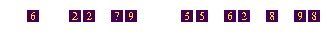

In [415]:
mdl = load_model('cnn_model.h5')
data_test = np.load('test.npz')
x_test, y_test = data_test['arr_0'], data_test['arr_1']

# y_test = keras.utils.to_categorical(y_test, 10)
x_test = cnn_model.preProcessImg(x_test, (x_test.shape[1:3]))

print('model and data loaded')
y_pred = mdl.predict_classes(x_test, verbose=0)
for k in np.argwhere(y_pred != y_test):
    print(y_pred[k], y_test[k])
    plt.subplot(1,len(y_pred),k+1)
    plt.imshow(np.squeeze(x_test[k]))
    plt.axis('off')


### 3.b.3 Recognize the digits via trained model (Inference)

In [400]:
import imp
import cnn_model
imp.reload(cnn_model)
x_train, y_train = cnn_model.genDataSet(100, (50,50))

[8 4 1 1 6 2]


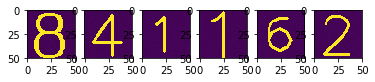

In [401]:
for k in list(range(6)):
    plt.subplot(1,6,k+1)
    plt.imshow(x_train[k])
print(y_train[0:6])

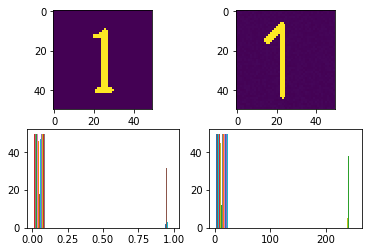

In [407]:
tmp = np.squeeze(x_test[0])  
plt.subplot(221)
plt.imshow(tmp)
plt.subplot(223)
_ = plt.hist(tmp)

k = np.argwhere(y_train==1)[0][0]
plt.subplot(222)
_ = plt.imshow(x_train[k])
plt.subplot(224)
_ = plt.hist(x_train[k])

In [178]:
import cnn_model

def recognizeDigit(mdl, img, thresh=0.5):
    rst = preProcessImg(img)
    d = mdl.predict_classes(rst)[0]
    print('\nresult = ', d)
    return d

puzzle = np.zeros((9,9))
plt.figure(2,figsize=(15,15))
for i in list(range(9)):
    for j in list(range(9)):
        if not flagEmpty[i][j]:
            puzzle[i][j] = recognizeDigit(mdl, img_mdl[i][j])
        
print(puzzle)

1/1 [==============================] - 0s

result =  1
1/1 [==============================] - 0s

result =  4
1/1 [==============================] - 0s

result =  1
1/1 [==============================] - 0s

result =  1
1/1 [==============================] - 0s

result =  7
1/1 [==============================] - 0s

result =  7
1/1 [==============================] - 0s

result =  1
1/1 [==============================] - 0s

result =  7
1/1 [==============================] - 0s

result =  0
1/1 [==============================] - 0s

result =  1
1/1 [==============================] - 0s

result =  1
1/1 [==============================] - 0s

result =  1
1/1 [==============================] - 0s

result =  5
1/1 [==============================] - 0s

result =  5
1/1 [==============================] - 0s

result =  7
1/1 [==============================] - 0s

result =  4
1/1 [==============================] - 0s

result =  7
1/1 [==============================] - 0s

result =  1
1/1 [=====

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
  32/1000 [..............................] - ETA: 0s
result (test) =  6
1/1 [==============================] - 0s

result (real) =  1


True

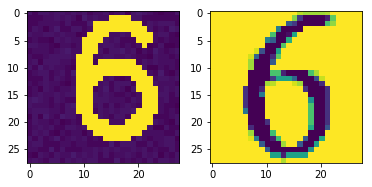

In [158]:
plt.subplot(121)
k = -1
for i in range(y_test.shape[0]):
    if y_test[i][6] == 1:
        k = i
        break
print(y_test[k])
plt.imshow(np.squeeze(x_test[k]))
plt.subplot(122)
tmp = np.squeeze(img_mdl[0][7])
plt.imshow(tmp)

print ('\nresult (test) = ', mdl.predict_classes(x_test)[k])
print ('\nresult (real) = ', mdl.predict_classes(preProcessImg(img_mdl[0][1]))[0])
cv2.imwrite('test.jpg', np.squeeze(x_test[k]))

In [114]:
y_test[0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Replace the URL with your own IPwebcam shot.jpg IP:port
# url='http://211.192.192.98:8080/shot.jpg'
url='file:///C:/Users/yuqyang/Desktop/example.JPG'

url='file:///C:/Users/yuqyang/Downloads/1479504130.jpg'

#cv2.namedWindow("Solver")

while True:
    # Use urllib to get the image and convert into a cv2 usable format
    imgResp=urllib.request.urlopen(url)
    imgNp=np.array(bytearray(imgResp.read()),dtype=np.uint8)
    img=cv2.imdecode(imgNp,flags=cv2.IMREAD_GRAYSCALE )

    print(img.shape)
    while min(img.shape[0:2]) > 1000:
        img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)

    # put the image on screen

    #To give the processor some less stress
    #time.sleep(0.1) 

    # extract digits
    edges = cv2.Canny(img, 30, 90)
    lines = cv2.HoughLines(edges, 2, np.pi /180, 300, 0, 0)

    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    img = cv2.drawContours(img, contours, -1, (255,0,0))

    #cv2.imshow('Solver',img)
    #cv2.waitKey()
    plt.imshow(img, cmap='gray')
    plt.show()
    
    break
    if 0xFF == ord('q'):
        break

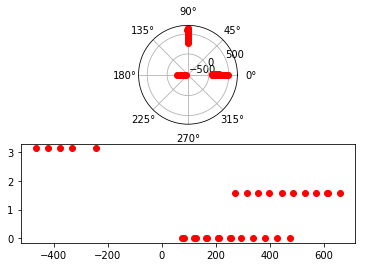

In [12]:
ln = np.squeeze(lines)
plt.figure(1)
ax = plt.subplot(211, projection='polar')
ax.plot(ln[:,1], ln[:,0], 'ro')
ax2 = plt.subplot(212)
ax2.plot(ln[:,0], ln[:,1], 'ro')